In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# An introduction to TensorFlow for astronomers

In this worksheet, we will go through an example of fitting a line to data using [TensorFlow](https://www.tensorflow.org/) to build the model combined with the standard astronomical Python stack.
To run this notebook, you will need to have the standard scientific Python packages installed: NumPy, SciPy, and Matplotlib.
You will also need TensorFlow. The installation instructions can be found [here](https://www.tensorflow.org/install/), but it's often enough to just run:

```bash
pip install -U --no-deps tensorflow
```

(This is generally better than using conda because the conda packages were really old when I last checked.)

## Data & model

To start, let's simulate some fake data.
We'll generate the data from a linear model and we'll assume that the error bars are unknown (we'll fit for the magnitude of the uncertainty in a minute).

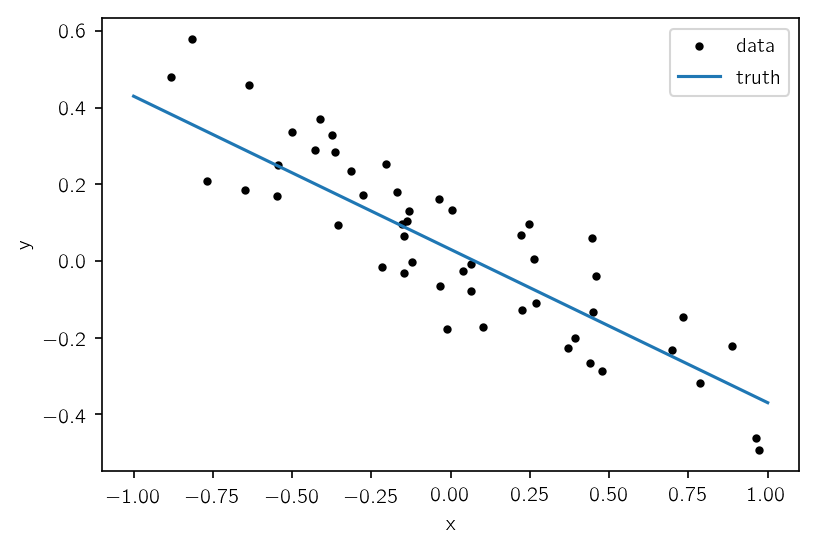

In [28]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

true_params = (-0.4, 0.03, 0.1)
x = np.sort(np.random.uniform(-1, 1, 50))
y = true_params[0] * x + true_params[1] + true_params[2] * np.random.randn(len(x))

plt.plot(x, y, ".k", label="data")
t = np.linspace(-1, 1, 5000)
plt.plot(t, true_params[0]*t+true_params[1], label="truth")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

We won't go into the mathematical details of this model here (if you're interested, check out [Hogg, Bovy, & Lang 2010](https://arxiv.org/abs/1008.4686)), but the basic idea is that we need to write down the following likelihood function for this model:

$$
\log p(y\,|\,m,\,b,\,s) = -\frac{1}{2}\,\sum_{n=1}^N \left[ \frac{(y_n - m\,x_n - b)^2}{s^2} + \log(2\,\pi\,s^2) \right]
$$

In NumPy, you might write this function as follows:

In [29]:
def np_log_like(x, y, m, b, s):
    model = m * x + b
    return -0.5*np.sum(((y-model)/s)**2+np.log(2*np.pi*s**2))

print("The log likelihood computed using numpy: {0}".format(np_log_like(x, y, *true_params)))

The log likelihood computed using numpy: 38.043974115093675


Now your job is to fill in the following function and re-write this in TensorFlow. (The docs are [here](https://www.tensorflow.org/api_docs/python/tf).)

In [30]:
import tensorflow as tf
print("Using TensorFlow version {0}".format(tf.__version__))

# The default type in tensorflow is float32, but we want to force float64 here.
T = tf.float64

# Convert the numpy arrays to tensors.
# This step of using the "constant" method isn't strictly necessary,
#  but it will come in handy later.
x_tensor = tf.constant(x, dtype=T)
y_tensor = tf.constant(y, dtype=T)

# These are the parameters that we will fit for.
# Most tensors are immutable so we need to call them "Variable"s if we
#  want to change them.
m_tensor = tf.Variable(true_params[0], dtype=T)
b_tensor = tf.Variable(true_params[1], dtype=T)
s_tensor = tf.Variable(true_params[2], dtype=T)

# This is the function that you should write.
# Hint: in many cases you can get a long way by taking numpy code and
#  converting "np" to "tf".
def tf_log_like(x, y, m, b, s):
    model = m * x + b
    return -0.5*tf.reduce_sum(((y-model)/s)**2+tf.log(2*np.pi*s**2))

# Now we execute this function to define the operations.
log_like = tf_log_like(x_tensor, y_tensor, m_tensor, b_tensor, s_tensor)
print("'log_like' is: {0}".format(log_like))

# And finally open a session to execute the model.
with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("The log likelihood computed using tensorflow: {0}"
          .format(session.run(log_like)))

Using TensorFlow version 1.7.0
'log_like' is: Tensor("mul_23:0", shape=(), dtype=float64)
The log likelihood computed using tensorflow: 38.043974115093675


If the value of the log likelihood of this cell isn't identical to the one above, edit your function until it is.
After that, think a bit about what is happening at each step of the code.
What does the value of `log_like` mean and why does it have this value?

## The "feed_dict"

One useful concept in TensorFlow is called the `feed_dict` and it is passed to the `session.run` method as a keyword argument.
It allows you to easily evaluate some part of your model for different values of any number of tensors without re-defining the full graph.
For example, to compute the log likelihood for a different slope, we could use the following code:

In [41]:
feed_dict = {
    m_tensor: 0.1,  # <-- NOTE: this is *not* a typo. The key should be
                    #           *the tensor*, not a string!
}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("The log likelihood for a slope of 0.1: {0}"
          .format(session.run(log_like, feed_dict=feed_dict)))

The log likelihood for a slope of 0.1: -121.37882419883077


This is generally most useful for parameters that you are fitting for, but it also works for other tensors.
For example, we can compute the likelihood for a different dataset as follows:

In [42]:
feed_dict = {
    y_tensor: np.zeros_like(y),
}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("The log likelihood for a dataset of zeros: {0}"
          .format(session.run(log_like, feed_dict=feed_dict)))

The log likelihood for a dataset of zeros: -19.321491806784884


## Gradients

One of the key benefits of TensorFlow is that it efficiently computes gradients of scalar functions with respect to any other tensors.
In the following cell, use the [`tf.gradients`](https://www.tensorflow.org/api_docs/python/tf/gradients) define an operation to compute the gradient of `log_like` with respect to `m_tensor`, `b_tensor`, and `s_tensor`.
Then, open a session, and evaluate this gradient (you should get something like: `[-48.6057, 52.6399, 122.76701]`).

In [37]:
grad = tf.gradients(log_like, [m_tensor, b_tensor, s_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(grad))

[-48.605709606726414, 52.639904617764444, 122.76707748749948]
